In [772]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, MissingIndicator
from IPython.display import display
import scipy.ndimage
from collections import defaultdict
import geopandas as gpd
import json, mapclassify

plt.rcParams["figure.figsize"] = (10,5)

Preamble: bring dataset into Pandas, print all columns, make sure everything looks right.

In [674]:
df = pd.read_csv('voting.csv').set_index('FIPS')

required_cols = [
    'minTempC', 'maxTempC', 'prcpMm', 'turnout'
]

for col in required_cols:
    df = df[df[col].notnull()]

print(f'{len(df)} rows in dataframe')
df.head()

2191 rows in dataframe


,stateFIPS,state,county,stateAbb,region,earlyVoting,democrat,republican,medianIncome,populationOver18,...,demState,closeElection,turnout,turnout2,haveSenate,closeSenate,closePresSenate,freezing,shareSameDay,shareRep
FIPS,,,,,,,,,,,,,,,,,,,,,
1005,1,Alabama,Barbour,AL,South,NoEarlyVoting,4871.0,5454,33.956,20879,...,729547.0,False,0.494516,0.505005,True,False,False,False,NaN,0.528232
1007,1,Alabama,Bibb,AL,South,NoEarlyVoting,1874.0,6738,39.776,17816,...,729547.0,False,0.483386,0.496913,True,False,False,False,NaN,0.782397
1009,1,Alabama,Blount,AL,South,NoEarlyVoting,2156.0,22859,46.212,44103,...,729547.0,False,0.567195,0.583634,True,False,False,False,NaN,0.913812
1011,1,Alabama,Bullock,AL,South,NoEarlyVoting,3530.0,1140,29.335,8278,...,729547.0,False,0.564146,0.572844,True,False,False,False,NaN,0.244111
1013,1,Alabama,Butler,AL,South,NoEarlyVoting,3726.0,4901,34.315,15547,...,729547.0,False,0.554898,0.564353,True,False,False,False,NaN,0.568100


In [4]:
print('Columns:', ', '.join(df.columns))

Columns: stateFIPS, state, county, stateAbb, region, earlyVoting, democrat, republican, medianIncome, populationOver18, medianAge, educTillHS, educSomeCollege, educCollegeUp, shareWhite, shareBlack, shareAsian, shareOtherRace, shareHispanic, prcpMm, minTempC, maxTempC, prcpMm1015, minTempC1015, maxTempC1015, demSenate, repSenate, totalSenate, registered, numPollWorkers, difficultToObtainPollWorkers, voted, votedPhysical, votedUOCAVA, votedAbsentee, votedProvisional, votedEarlyVoteCenter, votedByMail, votedOther, votedOtherExplanation, allowSameDay, repState, demState, closeElection, turnout, turnout2, haveSenate, closeSenate, closePresSenate, freezing, shareSameDay, shareRep


## Project overview

Show a secondary relationship between human climate effects and election outcomes by predicting turnout as a function of weather, and weather as a function of climate effects.
 
First step: demonstrate that weather is a factor in turnout by fitting a simple turnout model on rain and temperature.

In [742]:
ANY_RAIN_CUTOFF     = 0.02 # mm
AVERAGE_TEMPERATURE = 11.5 # degrees celcius

df_weather = df.copy()

df_weather['avgTemp'] = (df.minTempC + df.maxTempC)/2
df_weather['rain'] = df.prcpMm > ANY_RAIN_CUTOFF
df_weather['tempFromAvg'] = np.abs(df_weather.avgTemp - AVERAGE_TEMPERATURE)**2

FORMULA = """
    turnout ~ C(stateAbb) + medianIncome + medianAge + educTillHS
            + educSomeCollege + educCollegeUp + shareWhite
            + shareBlack + shareAsian + shareOtherRace + shareHispanic
            + numPollWorkers + allowSameDay
            + tempFromAvg + rain
"""

mod = smf.ols(formula=FORMULA, data=df_weather, )
res = mod.fit()
predicted_turnouts = res.predict()

res.summary()

/home/jgru/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/jgru/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jgru/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jgru/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                turnout   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     48.77
Date:                Thu, 01 Oct 2020   Prob (F-statistic):          5.93e-134
Time:                        17:03:30   Log-Likelihood:                 947.17
No. Observations:                 598   AIC:                            -1834.
Df Residuals:                     568   BIC:                            -1703.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0510      0.035     -1.455      0.146      -0.120       0.018
C(stateAbb)[T.AR]  2.256e-13   5.71e-14      3.954      0.000    1.14e-13    3.38e-13
C(stateAbb)[T.AZ] -7.493e-15   1.75e-15     -4.294      0.000   -1.09e-14   -4.07e-15
C(stateAbb)[T.CA]  9.236e-17   5.85e-16      0.158      0.875   -1.06e-15    1.24e-15
C(stateAbb)[T.CO]     0.0839      0.015      5.564      0.000       0.054       0.114
C(stateAbb)[T.CT]    -0.0289      0.027     -1.080      0.280      -0.082       0.024
C(stateAbb)[T.DC]    -0.0694      0.055     -1.272      0.204      -0.177       0.038
C(stateAbb)[T.DE]  2.271e-16   3.54e-17      6.421      0.000    1.58e-16    2.97e-16
C(stateAbb)[T.FL]  4.493e-16   1.16e-16      3.864      0.000    2.21e-16    6.78e-16
C(stateAbb)[T.GA]  1.126e-16   2.93e-17      3.839      0.000     5.5e-17     1.7e-16
C(stateAbb)[T.IA]     0.0566      0.013      4.332      0.000       0.031       0.082
C(stateAbb)[T.ID]    -0.0123      0.014     -0.902      0.367      -0.039       0.014
C(stateAbb)[T.IL] -7.506e-16   1.87e-16     -4.023      0.000   -1.12e-15   -3.84e-16
C(stateAbb)[T.IN]  4.161e-16   9.87e-17      4.215      0.000    2.22e-16     6.1e-16
C(stateAbb)[T.KS]  9.461e-16   2.28e-16      4.151      0.000    4.98e-16    1.39e-15
C(stateAbb)[T.KY]  2.884e-16      7e-17      4.123      0.000    1.51e-16    4.26e-16
C(stateAbb)[T.LA] -2.456e-16    6.1e-17     -4.024      0.000   -3.66e-16   -1.26e-16
C(stateAbb)[T.MA] -2.767e-16   7.26e-17     -3.810      0.000   -4.19e-16   -1.34e-16
C(stateAbb)[T.MD]    -0.0214      0.018     -1.156      0.248      -0.058       0.015
C(stateAbb)[T.ME]     0.0652      0.020      3.196      0.001       0.025       0.105
C(stateAbb)[T.MI]     0.0005      0.015      0.035      0.972      -0.028       0.029
C(stateAbb)[T.MN] -7.021e-16   1.69e-16     -4.158      0.000   -1.03e-15    -3.7e-16
C(stateAbb)[T.MO]  2.558e-16   5.65e-17      4.524      0.000    1.45e-16    3.67e-16
C(stateAbb)[T.MS]  3.016e-16   6.92e-17      4.360      0.000    1.66e-16    4.38e-16
C(stateAbb)[T.MT]     0.0254      0.013      1.951      0.052      -0.000       0.051
C(stateAbb)[T.NC]     0.0409      0.013      3.107      0.002       0.015       0.067
C(stateAbb)[T.ND]  4.116e-17   1.26e-17      3.274      0.001    1.65e-17    6.59e-17
C(stateAbb)[T.NE]  5.332e-17   1.16e-17      4.603      0.000    3.06e-17    7.61e-17
C(stateAbb)[T.NH]     0.0328      0.026      1.269      0.205      -0.018       0.084
C(stateAbb)[T.NJ]  9.113e-18   3.76e-18      2.426      0.016    1.73e-18    1.65e-17
C(stateAbb)[T.NM]    -0.0131      0.022     -0.586      0.558      -0.057       0.031
C(stateAbb)[T.NV]          0          0        nan        nan           0           0
C(stateAbb)[T.NY]          0          0        nan        nan           0

From the above regression, we can see that precipitation likely has a significant causal effect, depressing turnout by 0.42% depending on magnitude, as does extreme temperatures.  From here, our goal will be to predict climate effects on temperature and rainfall, compute hypothetical turnouts under the new weather conditions, and count election results under the new turnouts.  This makes the following assumptions:

 - Rain similarly affects Republican and Democratic turnout.
 - The big one is that climate change likely has greater effects on elections through environmental policy and politics than on turnout.  However, this is still an interesting thing to model, as I doubt it is as often discussed.
 - The environmental model will likely be flawed, as climate modeling is hard.
 
## Climate data

We pull in county-level temperature and precipitation data, generated in `climate_data.py`.

This has the two temperature fields (in degrees Celcius), precipitation measured in millimeters, and snowfall and depth in centimeters, all averaged for all the weather stations in the given county across each day in the given month.

In [477]:
with open("extra_data/monthly_county_weather_1900_to_2016.npy", "rb") as f:
    county_weather_raw = np.load(f)

with open('extra_data/ghcnd-to-county-id.json') as f:
    station_to_county = json.load(f)

county_labels = sorted(list(set(station_to_county.values())))

weather_fields = ['TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD'] # degrees C, degrees C, mm, cm, cm
county_weather_raw.shape # month, county, feature

(1404, 3138, 5)

Quick sanity check: we plot the average precipitation and max temperature for each November from 1900 to 2016, and see upwards trends.

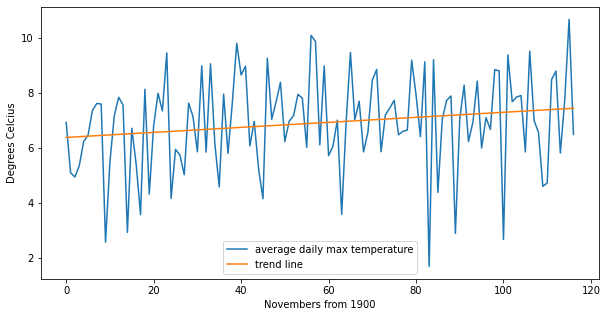

In [478]:
y = np.nanmean(county_weather_raw[11::12,:,1], axis=1)
x = np.arange(len(y))

result = sm.OLS(y,sm.add_constant(x), missing='drop').fit()

plt.plot(x, y, label='average daily max temperature')
plt.plot(x, x*result.params[1] + result.params[0], label='trend line')

plt.legend()
plt.ylabel('Degrees Celcius')
plt.xlabel('Novembers from 1900');

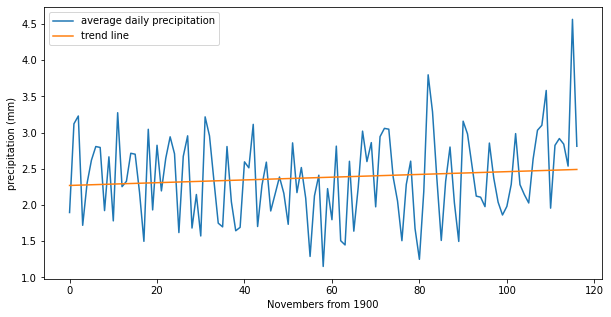

In [479]:
y = np.nanmean(county_weather_raw[11::12,:,2], axis=1)
x = np.arange(len(y))

result = sm.OLS(y,sm.add_constant(x), missing='drop').fit()

plt.plot(x, y, label='average daily precipitation')
plt.plot(x, x*result.params[1] + result.params[0], label='trend line')

plt.legend()
plt.ylabel('precipitation (mm)')
plt.xlabel('Novembers from 1900');

Unfortunately, our constructed weather dataset is missing a few counties, so we will eliminate those columns and reconstruct the dataset.

In [484]:
indicator = MissingIndicator(missing_values=np.nan, features='all')
x  = indicator.fit_transform(county_weather_raw[10::12,:,0]+county_weather_raw[10::12,:,1])
x |= indicator.fit_transform(county_weather_raw[10::12,:,2])

missing_county_locs = np.where(np.all(x.T, axis=1))[0]
county_weather_filtered = np.delete(county_weather, missing_county_locs, axis=1)

## Climate modeling

We now intend to model an expected change in temperature and precipitation due to climate change.  To do this, we will use PCA on a matrix where each row is a November, and each column is a county.  We will then take the first component, as we expect human climate change to be the largest effect.

To eliminate PCA from picking up on year-level effects such as storms, we apply a rolling mean smoothing filter over a 10 year period.  Then, we deal with missing data by imputing with the column median.

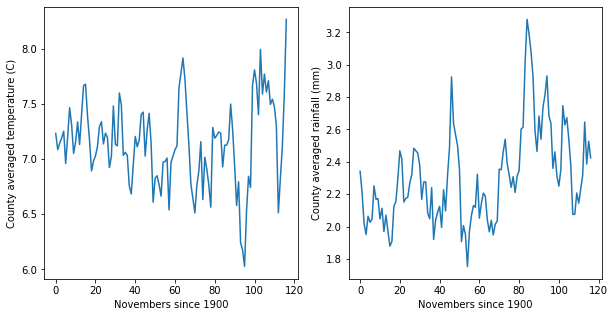

In [735]:
temperature = np.mean(county_weather_filtered[10::12,:,:2], axis=-1)
precip      = county_weather_filtered[10::12,:,2]

imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=True)
imputed_temperature = imputer.fit_transform(temperature)
imputed_precip      = imputer.fit_transform(precip)

MOVING_AVERAGE_SIZE = 5

imputed_temperature = scipy.ndimage.uniform_filter(imputed_temperature, size=MOVING_AVERAGE_SIZE, mode='nearest')
imputed_precip      = scipy.ndimage.uniform_filter(imputed_precip, size=MOVING_AVERAGE_SIZE, mode='nearest')

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(np.nanmean(imputed_temperature,axis=1))
ax1.set_xlabel('Novembers since 1900')
ax1.set_ylabel('County averaged temperature (C)');

ax2.plot(np.nanmean(imputed_precip,axis=1))
ax2.set_xlabel('Novembers since 1900')
ax2.set_ylabel('County averaged rainfall (mm)');

We next apply PCA, and plot the above temperature curve without the estimated global warming effect.  We see something nicely detrended.

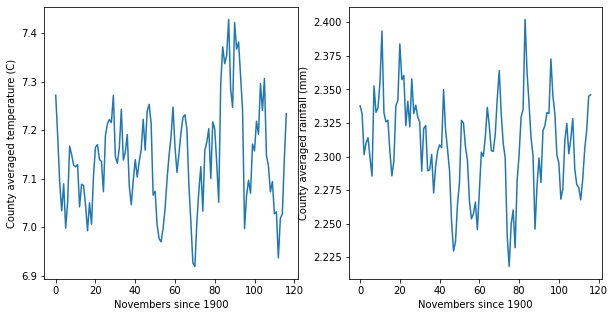

In [736]:
temp_pca = sklearn.decomposition.PCA(n_components=1)
prec_pca = sklearn.decomposition.PCA(n_components=1)

temp_transform = temp_pca.fit_transform(imputed_temperature)
prec_transform = prec_pca.fit_transform(imputed_precip)

# Plot without first component contrib (eg, plot without global warming)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(np.nanmean(imputed_temperature - (temp_transform @ temp_pca.components_),axis=1));
ax1.set_xlabel('Novembers since 1900')
ax1.set_ylabel('County averaged temperature (C)');

ax2.plot(np.nanmean(imputed_precip - (prec_transform @ prec_pca.components_),axis=1));
ax2.set_xlabel('Novembers since 1900')
ax2.set_ylabel('County averaged rainfall (mm)');

Finally, we can plot the average temperature change (again, in November) attributed to this component.  The peak value is 0.8 degrees, which nearly perfectly matches the 1 degree C change in temperature in the United States attributed to climate change in this time.

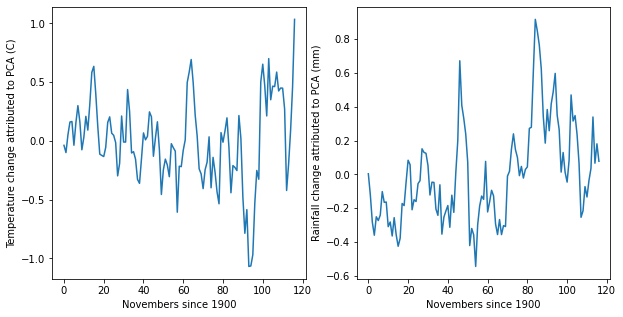

In [738]:
# County-averaged national november temperature change due to 1st PCA component
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(np.nanmean((temp_transform @ temp_pca.components_),axis=1));
ax1.set_xlabel('Novembers since 1900')
ax1.set_ylabel('Temperature change attributed to PCA (C)');

ax2.plot(np.nanmean((prec_transform @ prec_pca.components_),axis=1));
ax2.set_xlabel('Novembers since 1900')
ax2.set_ylabel('Rainfall change attributed to PCA (mm)');

We can extract the last row of this as the 2016 predicted climate change, and build a map of county IDs to climate change temperature effects.

In [495]:
county_labels_filtered = county_labels.copy()
for index in sorted(missing_county_locs, reverse=True):
    del county_labels_filtered[index]

temp_impact_2016 = (temp_transform @ temp_pca.components_)[-1]
prec_impact_2016 = (prec_transform @ prec_pca.components_)[-1]

county_impact = {
    county_labels_filtered[i]:(t, p)
    for i, (t,p) in enumerate(zip(temp_impact_2016, prec_impact_2016))
}

## Election outcomes

We've now computed expected differences in temperatures and rainfall due to climate change. Our final goal is to run our turnout model on our new predicted weather data and recompute the election outcomes.  Due to the scope of this project, we will compute outcomes by simply counting who wins the most votes in each state (which is not the reality in Nebraska), and assume that Democratic and Republican turnout are equally affected by weather.  However, our climate model is not perfect either, so this is perhaps OK.

This is also flawed because the given voting dataset  only has pertinent data for roughly half of all US counties, and even excludes entire states (for example, all of Alaska).

In [829]:
df_hypo = df.copy()

df_hypo['avgTemp'] = (df.minTempC + df.maxTempC)/2
df_hypo['tempFromAvg'] = (df_hypo.avgTemp - AVERAGE_TEMPERATURE)**2
df_hypo['rain'] = df_hypo.prcpMm > ANY_RAIN_CUTOFF

missing_counties = set()
state_deltas = defaultdict(lambda: [0,[]])
state_margins = defaultdict(lambda: 0)

rain_coef, temp_coef = res.params['rain[T.True]'], res.params.tempFromAvg
for county, (temp_impact, prec_impact) in tqdm(county_impact.items()):
    if not county in df_hypo.index:
        missing_counties.add(county)
        continue
        
    old_weather_effect = temp_coef*df_hypo.loc[county].tempFromAvg + rain_coef*df_hypo.loc[county].rain
    
    df_hypo.at[county, 'avgTemp']     = df_hypo.loc[county].avgTemp - temp_impact
    df_hypo.at[county, 'prcpMm']      = min(0,df_hypo.loc[county].prcpMm - prec_impact)
    df_hypo.at[county, 'rain']        = df_hypo.loc[county].prcpMm > ANY_RAIN_CUTOFF
    df_hypo.at[county, 'tempFromAvg'] = (df_hypo.loc[county].avgTemp - AVERAGE_TEMPERATURE)**2
    
    new_weather_effect = temp_coef*df_hypo.loc[county].tempFromAvg + rain_coef*df_hypo.loc[county].rain
    
    old_turnout = df_hypo.loc[county].turnout
    new_turnout = old_turnout + new_weather_effect - old_weather_effect
    
    mult = new_turnout/old_turnout - 1
    
    record = df_hypo.loc[county]
    
    state_margins[record.stateAbb] += record.democrat - record.republican
    state_deltas[record.stateAbb][0] += record.democrat * mult - record.republican * mult
    
    if not np.isnan(record.demSenate) and not np.isnan(record.repSenate):
        state_deltas[record.stateAbb][1].append(record.demSenate * mult - record.repSenate * mult)

state_deltas = {s:(int(round(p)), int(round(sum(se)/len(se)) if len(se)>0 else 0)) for s, (p, se) in state_deltas.items()}
state_mults  = {state:p/abs(state_margins[state]) for state, (p,s) in state_deltas.items()}

pd.DataFrame({
    'State': list(state_deltas.keys()),
    'Pres towards Democrats':[v[0] for v in state_deltas.values()],
    'Senate towards Democrats':[v[1] for v in state_deltas.values()],
}).set_index('State')

100%|██████████| 3058/3058 [00:08<00:00, 363.79it/s]


,Pres towards Democrats,Senate towards Democrats
State,,
AL,-2492,-4532
AZ,-259,-1094
AR,-5629,-5997
CA,8145,0
CO,-9,2
CT,-22,252
DE,0,0
DC,-176,0
FL,-972,-1068


In conclusion: the outcome stays the same.  However, a few states were moved by a greater amount than New Hampshire's 2701 presidential vote margin, which is neat.  Most states moved towards Republicans, which is also interesting, but makes sense given the race was won by Republicans.  In general, it looks like climate change physically leads to less polarized elections.

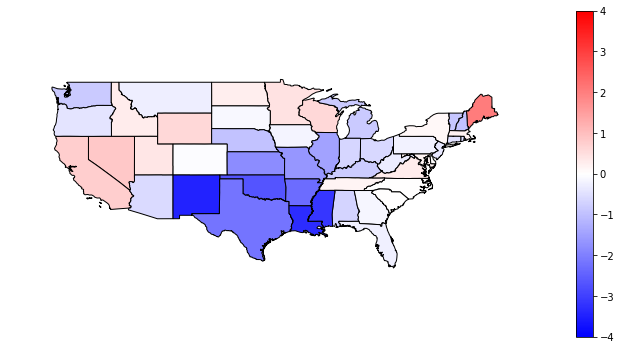

In [831]:
import geoplot
import matplotlib.colors as mcol


usa = gpd.read_file('./extra_data/state_shapes/states.shp')[1:50] # ignore AK and HI
pres_deltas = 100*np.array([state_mults[c] for c in usa.state_abbr])

geoplot.choropleth(
    usa, hue=pres_deltas, norm=mcol.Normalize(vmin=-4, vmax=4),
    cmap = 'bwr', figsize=(12, 6), legend=True, 
)

The above figure attempts to illustrate the physical impact of climate change on the 2016 election by estimating the attributed vote change in each state to physical climate change effects, scaled by the size of the margin in that state (legend in percent).